In [1]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:

clusters_list = run("test/sara_reads/jfdminion11_sara_reads_containments.paf")

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [3]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
247,3,16033,0044ae37-3583-4e92-9ad5-d92e6649890b,248
552,2,3607,00c6ca6a-8931-48bd-8cbe-456748f8e7be,553
73,2,31734,01401b0f-9833-45b3-86e4-595e4201db27,74
12,3,48600,01aaf302-5fc8-4715-b416-75dfca747471,13
568,2,3096,02a399ba-4a5d-424c-8e60-21baf1c2cf0c,569


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [4]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster,transform
271,15,14248,2e33a582-1b9e-4709-9621-c87475b74802,272,3.906891
185,11,20123,83df781d-8381-4b37-bd94-714907afdf74,186,3.459432
36,10,38888,e0ec1762-9626-4055-b597-eef6e08c7046,37,3.321928
172,9,20995,f060bc4f-a897-4060-94c8-48f7b26b84f3,173,3.169925
65,8,33033,43cc8234-d764-4a3f-b859-03a117ad1446,66,3.000000


<Axes: >

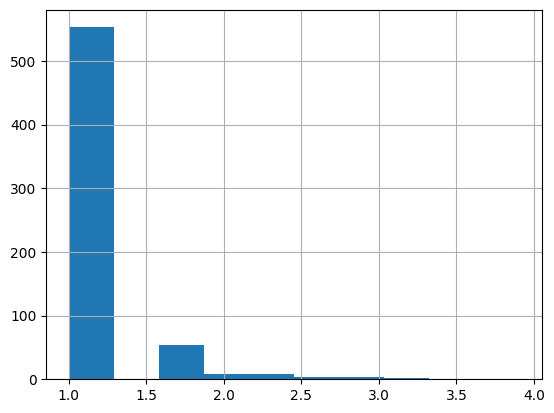

In [5]:
clusters['transform'].hist()

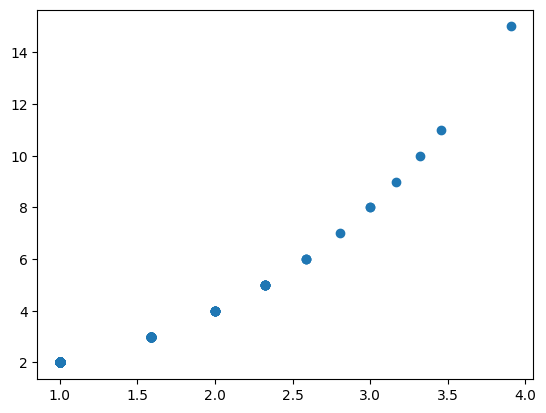

In [6]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

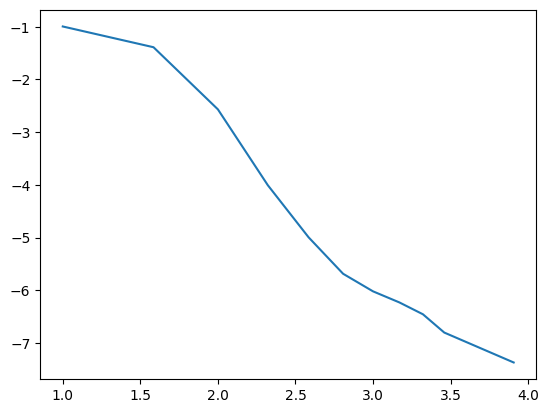

In [7]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [8]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
if len(local_min) < 1:
    min_coverage = 5
else:
    min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  5


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [9]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [10]:
convert_fq_to_fa('test/sara_reads/jfdminion11_sara_reads_sample.sorted.fastq','test/sara_reads/jfdminion11_sara_reads_sample.sorted.fasta')

37543 sequences converted to fasta


'test/sara_reads/jfdminion11_sara_reads_sample.sorted.fasta'

In [11]:
fasta = 'test/sara_reads/jfdminion11_sara_reads_sample.sorted.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [12]:
## Get the real mt sequences
# with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
#     ids_mt = handle_ids_mt.read().splitlines()
#     ids_mt = [i[1:] for i in ids_mt]

In [13]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.080224,0.051482,0.033098,0.043644,0.043998,0.025824,0.038305,0.044252,0.032987,0.020462,...,0.003637,0.003206,0.003084,0.044971,0.018218,0.022994,0.029649,0.019346,0.029229,db22ba5b-dd2a-43ad-ae65-d68edd33f64b
1,0.072109,0.050516,0.030229,0.044044,0.040436,0.026667,0.038569,0.041283,0.033998,0.023070,...,0.004605,0.004914,0.003723,0.042601,0.020355,0.025361,0.027572,0.018786,0.030985,1c3c61e8-5cc3-4b40-b804-d990b8416a7d
2,0.080567,0.055460,0.031515,0.041483,0.049238,0.026794,0.039765,0.041870,0.032846,0.022274,...,0.003792,0.003235,0.003514,0.043526,0.018126,0.024162,0.025199,0.017429,0.032289,0a363409-b028-4657-8cba-3bdf700e163a
3,0.052605,0.032172,0.027578,0.040157,0.022112,0.024220,0.032304,0.037671,0.031118,0.026689,...,0.010817,0.006965,0.009533,0.038840,0.023660,0.017584,0.035942,0.032946,0.037754,65126892-2a30-4eb5-82a9-9aa62b30788c
4,0.080357,0.049409,0.032225,0.042807,0.039898,0.025861,0.040476,0.045989,0.032157,0.022322,...,0.005547,0.005444,0.005053,0.046601,0.020162,0.023360,0.028226,0.017269,0.032854,7c656dae-37b6-44a9-bda0-515390ac1cbb


# Dimensionality reduction with PCA and clustering with k-means 

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [15]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [16]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([0.00316681, 0.0017414 ])

In [17]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
#kmer_reduction['mt'] = (kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] > min_coverage]
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform
36,0.007664,0.025684,e0ec1762-9626-4055-b597-eef6e08c7046,10,38888,37,3.321928
65,-0.004616,-0.007977,43cc8234-d764-4a3f-b859-03a117ad1446,8,33033,66,3.000000
95,-0.002259,-0.001622,eada32de-2fda-41a4-8901-d492977ba0d9,6,29188,96,2.584963
115,-0.003415,-0.010308,3e90cd01-93de-40c6-b84f-dde33837fff3,8,26375,116,3.000000
140,0.000003,0.005959,248b74ad-bce5-4332-956f-085a3d830314,7,23770,141,2.807355
172,0.049024,0.086188,f060bc4f-a897-4060-94c8-48f7b26b84f3,9,20995,173,3.169925
185,0.016134,0.069767,83df781d-8381-4b37-bd94-714907afdf74,11,20123,186,3.459432
236,-0.005503,0.001419,8f816083-5064-49f4-89b4-242db2e0c058,6,16313,237,2.584963
271,0.001526,0.000604,2e33a582-1b9e-4709-9621-c87475b74802,15,14248,272,3.906891
321,-0.004428,0.003659,c54d6ce9-5bf6-4232-af6b-70ec0c1c02ac,6,11660,322,2.584963


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

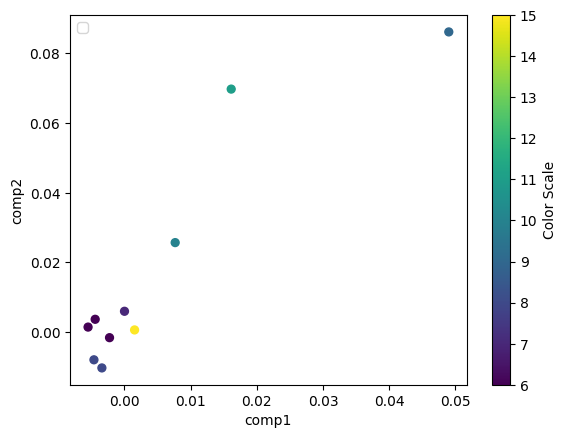

In [18]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=32)#kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [19]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.002460472034401894.
Iteration 1, inertia 0.0016550714571131535.
Converged at iteration 1: strict convergence.


Text(0, 0.5, 'comp2')

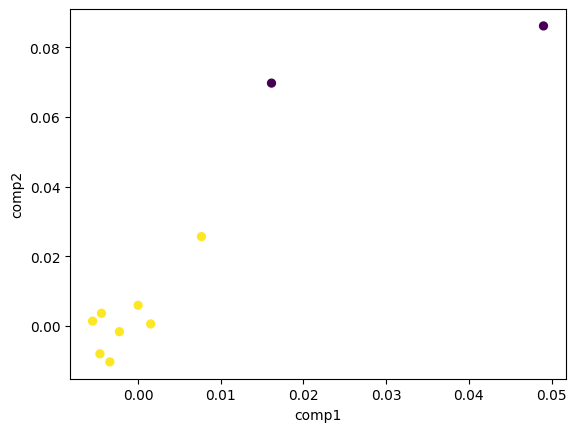

In [20]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=32)#kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [21]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].median().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.sort_values('coverage')

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,cluster_prediction
172,0.049024,0.086188,f060bc4f-a897-4060-94c8-48f7b26b84f3,9,20995,173,3.169925,0
185,0.016134,0.069767,83df781d-8381-4b37-bd94-714907afdf74,11,20123,186,3.459432,0


In [22]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/sara_reads/mt_reads_v1.fasta')

20 reads retrieved
